In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# example of noise between fully connected layers
from keras.layers import Dense
from keras.layers import GaussianNoise
from keras.layers import Activation

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

dataset = MNIST(root='data/', download=True, transform=ToTensor())

val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/opt/miniconda3/lib/python3.8/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/opt/miniconda3/lib/python3.8/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: dlopen(/opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so, 6): Symbol not found: _SecKeyCopyExternalRepresentation
  Referenced from: /opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/../libtensorflow_framework.2.dylib
  Expected in: /System/Library/Frameworks/Security.framework/Versions/A/Security
 in /opt/miniconda3/lib/python3.8/site-packages/tensorflow/python/../libtensorflow_framework.2.dylib


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [4]:
pip install --user --upgrade tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu
ERROR: No matching distribution found for tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow==2.2

     |████████████████████████████████| 175.4 MB 38 kB/s s eta 0:00:01   |███▏                            | 17.1 MB 4.1 MB/s eta 0:00:39     |███████████████████████████     | 147.7 MB 23.6 MB/s eta 0:00:02
     |████████████████████████████████| 28.8 MB 16.3 MB/s eta 0:00:01     |█████████████████████████████▊  | 26.8 MB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 30.8 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 21.8 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled 

In [2]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # second hidden layer
        self.linear1a = nn.Linear(hidden_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Second hidden layer
        out2 = self.linear1a(out)
        out2 = F.relu(out2)
        # Get predictions using output layer
        out2 = self.linear2(out2)
        return out2
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [4]:
input_size = 784
hidden_size = 512
# hidden_size = 256
# hidden_size = 1024
num_classes = 10

model = MnistModel(input_size, hidden_size=512, out_size=num_classes)

In [5]:
for t in model.parameters():
    print(t.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [6]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3022587299346924
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0463, -0.0013,  0.0683, -0.0044, -0.0650,  0.0334, -0.0164, -0.0413,
          0.0395, -0.0209],
        [-0.0545,  0.0115,  0.0606, -0.0005, -0.0746,  0.0492, -0.0169, -0.0438,
          0.0602, -0.0304]])


In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

torch.Size([128, 1, 28, 28])
cpu


In [8]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [9]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([1, 4, 7, 4, 2, 5, 1, 0, 8, 2, 1, 0, 2, 9, 5, 7, 4, 6, 8, 4, 4, 0, 2, 4,
        3, 4, 8, 2, 3, 2, 0, 3, 6, 7, 7, 7, 7, 3, 2, 6, 1, 8, 0, 2, 1, 1, 0, 6,
        7, 1, 0, 5, 7, 0, 6, 9, 3, 2, 3, 3, 7, 7, 8, 1, 9, 4, 9, 3, 8, 8, 1, 3,
        7, 0, 6, 4, 4, 2, 8, 0, 3, 9, 2, 7, 2, 3, 8, 8, 1, 9, 5, 1, 9, 1, 5, 6,
        8, 3, 9, 1, 7, 5, 2, 9, 1, 3, 1, 0, 6, 9, 1, 8, 1, 4, 7, 7, 3, 5, 6, 4,
        6, 7, 6, 7, 9, 1, 8, 2, 5, 0, 1, 7, 3, 2, 0, 1, 9, 9, 8, 2, 1, 6, 0, 5,
        4, 0, 9, 5, 2, 1, 5, 2, 2, 5, 7, 8, 2, 0, 3, 6, 0, 2, 1, 4, 7, 0, 1, 1,
        3, 5, 0, 8, 9, 0, 9, 8, 9, 3, 1, 1, 6, 3, 8, 4, 9, 9, 8, 1, 1, 6, 4, 7,
        6, 5, 6, 7, 6, 7, 8, 9, 0, 1, 7, 1, 1, 8, 6, 6, 0, 7, 5, 9, 3, 3, 5, 8,
        7, 1, 6, 5, 1, 0, 6, 0, 9, 1, 1, 6, 6, 1, 0, 8, 2, 2, 4, 4, 2, 2, 0, 1,
        8, 8, 5, 6, 1, 8, 3, 1, 0, 9, 7, 7, 6, 4, 9, 7])


In [10]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear1a): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

In [22]:
history += fit(5, 0.5, model, train_loader, val_loader)

In [17]:
history += fit(5, 0.1, model, train_loader, val_loader)

In [18]:
history += fit(5, 0.01, model, train_loader, val_loader)

In [19]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

NameError: name 'history' is not defined

In [23]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

NameError: name 'history' is not defined

In [24]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 8


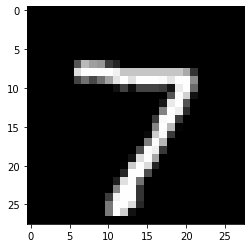

In [25]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))